In [1]:
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Cloning into 'vision'...
remote: Enumerating objects: 509824, done.
remote: Counting objects: 100% (23434/23434), done.
remote: Compressing objects: 100% (1171/1171), done.
remote: Total 509824 (delta 22277), reused 23341 (delta 22224), pack-reused 486390
Receiving objects: 100% (509824/509824), 987.44 MiB | 13.26 MiB/s, done.
Resolving deltas: 100% (475512/475512), done.
fatal: not a git repository (or any of the parent directories): .git


In [10]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from skimage import io
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.faster_rcnn import FasterRCNN_ResNet50_FPN_Weights
from torch.utils.tensorboard import SummaryWriter
from torchvision.ops import complete_box_iou_loss
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from engine import train_one_epoch, evaluate
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2
import numpy as np

In [11]:
from torch.utils.data import DataLoader

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
from torchvision import transforms

In [6]:
!unzip drive/MyDrive/indabaX/train.zip -d ./

Archive:  drive/MyDrive/indabaX/train.zip
   creating: ./train/
  inflating: ./train/ID_000343.png   
  inflating: ./train/ID_000410.png   
  inflating: ./train/ID_000242.png   
  inflating: ./train/ID_000316.png   
  inflating: ./train/ID_000255.png   
  inflating: ./train/ID_000220.png   
  inflating: ./train/ID_000424.png   
  inflating: ./train/ID_000384.png   
  inflating: ./train/ID_000090.png   
  inflating: ./train/ID_000365.png   
  inflating: ./train/ID_000577.png   
  inflating: ./train/ID_000411.png   
  inflating: ./train/ID_000019.png   
  inflating: ./train/ID_000291.png   
  inflating: ./train/ID_000257.png   
  inflating: ./train/ID_000399.png   
  inflating: ./train/ID_000390.png   
  inflating: ./train/ID_000371.png   
  inflating: ./train/ID_000401.png   
  inflating: ./train/ID_000379.png   
  inflating: ./train/ID_000357.png   
  inflating: ./train/ID_000511.png   
  inflating: ./train/ID_000445.png   
  inflating: ./train/ID_000561.png   
  inflating: ./train/ID_

In [13]:
train_data = pd.read_csv("drive/MyDrive/indabaX/Train.csv")
images = sorted(os.listdir("./train"))

In [14]:
mapID = dict(zip(sorted(train_data["Image_ID"].unique()),images))
train_data["Image_ID"] = train_data["Image_ID"].map(mapID)
train_data.head()

,Image_ID,ToothClass,Xmin,Ymin,Xmax,Ymax
0,ID_000000.png,33,284,315,325,361
1,ID_000000.png,37,372,119,448,193
2,ID_000000.png,47,40,114,113,186
3,ID_000000.png,35,325,236,379,287
4,ID_000000.png,41,200,362,237,411


In [15]:
train_data.columns = ["Image"]+train_data.columns[1:].tolist()
train_data.head()

,Image,ToothClass,Xmin,Ymin,Xmax,Ymax
0,ID_000000.png,33,284,315,325,361
1,ID_000000.png,37,372,119,448,193
2,ID_000000.png,47,40,114,113,186
3,ID_000000.png,35,325,236,379,287
4,ID_000000.png,41,200,362,237,411


In [16]:
MAP = dict(zip(sorted(train_data["ToothClass"].unique()),list(map(lambda x:"Class_"+str(x),sorted(train_data["ToothClass"].unique())))))

In [17]:
train_data["ToothClass"] = train_data["ToothClass"].map(MAP)
train_data.head()

,Image,ToothClass,Xmin,Ymin,Xmax,Ymax
0,ID_000000.png,Class_33,284,315,325,361
1,ID_000000.png,Class_37,372,119,448,193
2,ID_000000.png,Class_47,40,114,113,186
3,ID_000000.png,Class_35,325,236,379,287
4,ID_000000.png,Class_41,200,362,237,411


In [18]:
classes = (train_data["ToothClass"].values)

In [19]:
range(len(train_data["ToothClass"].unique()))

range(0, 32)

In [20]:
Map_classes = dict(zip(train_data["ToothClass"].unique(),range(len(train_data["ToothClass"].unique()))))
train_data["ToothClass"] = train_data["ToothClass"].map(Map_classes)
train_data.head()

,Image,ToothClass,Xmin,Ymin,Xmax,Ymax
0,ID_000000.png,0,284,315,325,361
1,ID_000000.png,1,372,119,448,193
2,ID_000000.png,2,40,114,113,186
3,ID_000000.png,3,325,236,379,287
4,ID_000000.png,4,200,362,237,411


In [21]:
train_data["ToothClass"].astype("category").cat.codes

0         0
1         1
2         2
3         3
4         4
         ..
16008    19
16009    17
16010    24
16011    29
16012    18
Length: 16013, dtype: int8

In [22]:
class TothAndBox(Dataset):
    def __init__(self,file_id, df, index,transform=None):
        self.df = df
        self.file_id = file_id
        self.root_dir = "./train"
        self.index = index
        self.transform = transform
    def __len__(self):
      return len(self.index)

    def __getitem__(self,idx):
      unique_image = self.file_id[self.index[idx]]

      img_name = os.path.join(self.root_dir,unique_image)
      boxes = self.df.loc[self.df['Image'] == unique_image].values[:,2:].astype(float)

      image = cv2.imread(img_name)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
      image /=255.0
      target = {}

      boxes = torch.tensor(boxes,dtype=torch.float32)
      labels = self.df.loc[self.df['Image'] == unique_image].values[:,1].astype(int)

      area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
      iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
      image_id = int(idx)

      target["boxes"] = torch.as_tensor(boxes)
      target["area"] = area
      target["labels"] = torch.as_tensor(labels,dtype=torch.int64)
      target["iscrowd"] = iscrowd
      target["image_id"] = image_id
      if self.transform:
        sample = self.transform(image = image,
                                     bboxes = target['boxes'],
                                     labels = target["labels"])
        image = sample['image']
        target['boxes'] = torch.Tensor(sample['bboxes'])
      return image, target

In [23]:
def get_transform(train):

    if train:
        return A.Compose([
                            A.HorizontalFlip(0.5),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
indexs = range(train_data["Image"].unique().shape[0])

train_ind,val_ind = train_test_split(indexs,test_size=0.2)

In [26]:
unique_images = train_data['Image'].unique()

train_Dataset = TothAndBox(unique_images,train_data,indexs,transform= get_transform(train=True))
val_Dataset = TothAndBox(unique_images,train_data,val_ind,transform= get_transform(train=False))

In [27]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [28]:
train_loaded = DataLoader(train_Dataset, batch_size=32, shuffle=True,collate_fn=collate_fn)
test_loaded = DataLoader(val_Dataset, batch_size=32, shuffle=True,collate_fn=collate_fn)

In [29]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
num_classes = len(train_data['ToothClass'].unique())
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [30]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
num_epochs= 5


In [31]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
for epoch in range(num_epochs):
  train_one_epoch(model, optimizer, train_loaded, device, epoch, print_freq=10)
  lr_scheduler.step()
  evaluate(model, test_loaded, device=device)


Epoch: [0]  [ 0/38]  eta: 0:02:55  lr: 0.000280  loss: 5.1052 (5.1052)  loss_classifier: 3.1726 (3.1726)  loss_box_reg: 0.8291 (0.8291)  loss_objectness: 1.0666 (1.0666)  loss_rpn_box_reg: 0.0370 (0.0370)  time: 4.6299  data: 0.5174  max mem: 19280
Epoch: [0]  [10/38]  eta: 0:01:36  lr: 0.002980  loss: 2.7280 (3.2529)  loss_classifier: 1.7604 (2.0900)  loss_box_reg: 0.8946 (0.8782)  loss_objectness: 0.0689 (0.2647)  loss_rpn_box_reg: 0.0159 (0.0201)  time: 3.4588  data: 0.5076  max mem: 19438
Epoch: [0]  [20/38]  eta: 0:01:01  lr: 0.005680  loss: 2.1369 (2.6685)  loss_classifier: 1.1978 (1.6142)  loss_box_reg: 0.8946 (0.8866)  loss_objectness: 0.0361 (0.1493)  loss_rpn_box_reg: 0.0159 (0.0184)  time: 3.3411  data: 0.5036  max mem: 19438
Epoch: [0]  [30/38]  eta: 0:00:27  lr: 0.008380  loss: 1.9384 (2.4177)  loss_classifier: 1.0321 (1.4183)  loss_box_reg: 0.8826 (0.8785)  loss_objectness: 0.0112 (0.1042)  loss_rpn_box_reg: 0.0139 (0.0167)  time: 3.3309  data: 0.4986  max mem: 19438
Epoc

In [32]:
data = next(iter(test_loaded))

In [33]:
img = data[0][1]
label = data[1][1]['labels']
boxes = data[1][1]['boxes']

In [34]:
model.eval()
with torch.no_grad():
  output = model([img.to(device)])

In [35]:
output

[{'boxes': tensor([[113.2562, 276.2321, 170.1975, 324.2488],
          [193.1711, 378.1473, 250.1862, 423.5445],
          [326.7019, 280.3724, 387.6570, 332.0794],
          [247.6133, 389.7562, 305.0238, 433.4528],
          [ 90.5645, 231.9264, 153.7311, 280.8640],
          [297.8222, 367.2722, 334.4667, 409.4392],
          [349.1253, 239.0867, 408.4225, 289.1789],
          [159.3465, 357.4818, 197.9670, 404.0657],
          [354.6639, 166.6184, 429.5927, 245.6563],
          [324.4344, 333.5319, 362.9398, 375.7021],
          [ 69.3749, 159.8131, 146.1393, 237.7931],
          [378.2284, 115.9551, 446.6331, 181.4841],
          [125.8294, 328.0043, 162.2691, 371.4044],
          [ 55.4642, 102.9875, 121.8899, 173.0025],
          [324.5753, 333.0182, 361.9269, 376.3016],
          [354.5512, 168.5748, 432.5325, 248.3173],
          [ 69.7096, 159.7381, 145.1866, 241.4272],
          [247.6175, 390.5896, 303.1841, 434.0194],
          [295.6052, 365.9647, 332.5841, 409.6082],
   

In [36]:
scores = output[0]["scores"]
threshold = 0.5
keep = scores > threshold

# Index the scores and other relevant fields based on the threshold
filtered_boxes = output[0]["boxes"][keep]
filtered_labels = output[0]["labels"][keep]
filtered_scores = output[0]["scores"][keep]

In [37]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [38]:
def plot_image(boxes,img):
  fig, ax = plt.subplots()
  ax.imshow(img.permute(1, 2, 0))
  for box in boxes:
    x = box[0]
    y = box[1]
    width = box[2] - box[0]
    height = box[3] - box[1]
    rectangle = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rectangle)
  plt.xlabel("X-axis")
  plt.ylabel("Y-axis")
  plt.title("Plot with Bounding Boxes [xmin, ymin, xmax, ymax]")
  plt.grid(True)
  plt.show()

In [39]:
filtered_boxes = filtered_boxes.cpu().numpy().astype(int)

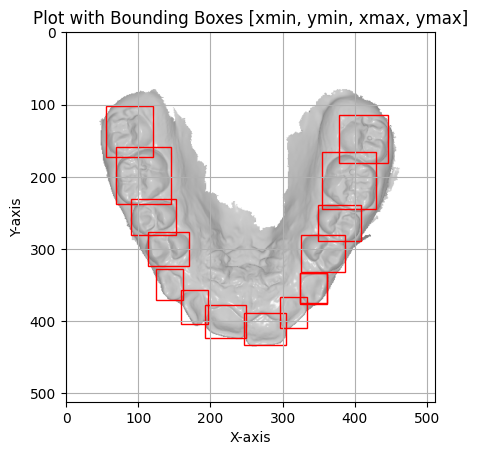

In [40]:
plot_image(filtered_boxes,img)

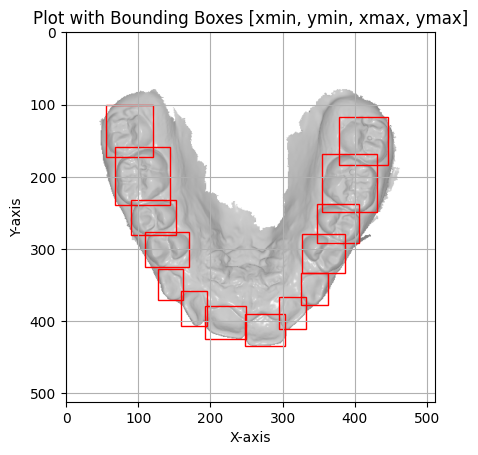

In [41]:
plot_image(boxes,img)

In [ ]:
plt.imshow(img.permute(1, 2, 0))

In [ ]:
label

tensor([13, 10,  4,  7, 11, 12,  0,  8,  9,  5,  3,  6,  1,  2])

In [ ]:
filtered_labels

tensor([ 4,  9, 10,  4,  4, 17], device='cuda:0')